In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
from sklearn.model_selection import train_test_split

from skimage.util import montage as montage2d

In [2]:
all_images=glob(os.path.join(r"D:\Spring_2023\Statistical Machine Learning\3d_data\archive",'3d_images','IMG_*'))


In [3]:
# show some of the files
# all_images=glob(os.path.join(BASE_IMG_PATH,'3d_images','IMG_*'))
print(len(all_images),' matching files found:',all_images[0])
train_paths, test_paths = train_test_split(all_images, random_state = 2018, test_size = 0.5)
print(len(train_paths), 'training size')
print(len(test_paths), 'testing size')

4  matching files found: D:\Spring_2023\Statistical Machine Learning\3d_data\archive\3d_images\IMG_0002.nii.gz
2 training size
2 testing size


In [4]:
DS_FACT = 8 # downscale
def read_all_slices(in_paths, rescale = True):
    cur_vol = np.expand_dims(np.concatenate([nib.load(c_path).get_fdata()[:, ::DS_FACT, ::DS_FACT] 
                                          for c_path in in_paths], 0), -1)
    if rescale:
        return (cur_vol.astype(np.float32) + 500)/2000.0
    else:
        return cur_vol/255.0
    
    
def read_both(in_paths):
    in_vol = read_all_slices(in_paths)
    in_mask = read_all_slices(map(lambda x: x.replace('IMG_', 'MASK_'), in_paths), rescale = False)
    return in_vol, in_mask


def montage_nd(in_img):
    if len(in_img.shape)>3:
        return montage2d(np.stack([montage_nd(x_slice) for x_slice in in_img],0))
    elif len(in_img.shape)==3:
        return montage2d(in_img)
    else:
        warn('Input less than 3d image, returning original', RuntimeWarning)
        return in_img

train (418, 64, 64, 1) mask (418, 64, 64, 1)
test (790, 64, 64, 1) mask (790, 64, 64, 1)


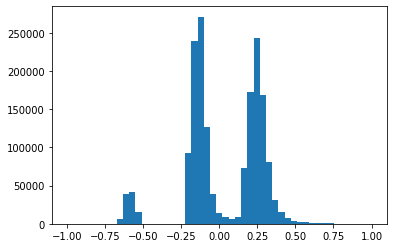

In [5]:
train_vol, train_mask = read_both(train_paths)
test_vol, test_mask = read_both(test_paths)
print('train', train_vol.shape, 'mask', train_mask.shape)
print('test', test_vol.shape, 'mask', test_mask.shape)
plt.hist(train_vol.ravel(), np.linspace(-1, 1, 50));

In [6]:

# all_vol, all_mask = read_both(all_images)

# plt.hist(all_vol.ravel(), np.linspace(-1, 1, 50));

(16, 10, 64, 64, 1) (16, 10, 64, 64, 1)


Text(0.5, 1.0, 'Out Batch')

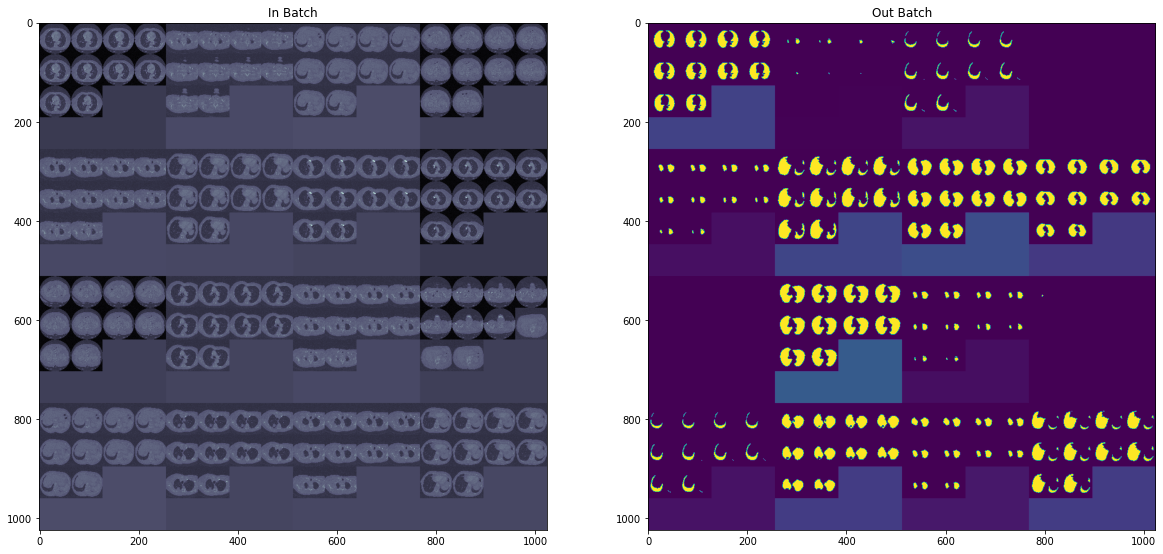

In [7]:
def gen_chunk(in_img, in_mask, slice_count = 10, batch_size = 16):
    while True:
        img_batch = []
        mask_batch = []
        for _ in range(batch_size):
            s_idx = np.random.choice(range(in_img.shape[0]-slice_count))
            img_batch += [in_img[s_idx:(s_idx+slice_count)]]
            mask_batch += [in_mask[s_idx:(s_idx+slice_count)]]
        yield np.stack(img_batch, 0), np.stack(mask_batch, 0)
# training we use larger batch sizes with fewer slices
train_gen = gen_chunk(train_vol, train_mask)
# for validation we use smaller batches with more slices
valid_gen = gen_chunk(test_vol, test_mask, slice_count = 100, batch_size = 1)
x_out, y_out = next(train_gen)
print(x_out.shape, y_out.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_nd(x_out[...,0]), cmap = 'bone')
ax1.set_title('In Batch')
ax2.imshow(montage_nd(y_out[...,0]))
ax2.set_title('Out Batch')

In [8]:
# (next(all_gen)[0]).shape

# def read_all_slices(in_paths, rescale = True):
#     cur_vol = np.expand_dims(np.concatenate([nib.load(c_path).get_fdata()[:, ::DS_FACT, ::DS_FACT] 
#                                           for c_path in in_paths], 0), -1)
#     if rescale:
#         return (cur_vol.astype(np.float32) + 500)/2000.0
#     else:
#         return cur_vol/255.0

# test = [all_images[0]][0]



# img_batch = []
# in_img = np.expand_dims(np.concatenate(nib.load(test).get_fdata()[:, ::8, ::8], 0), -1)
# slice_count = 32
# for _ in range(4):
#     s_idx = np.random.choice(range(in_img.shape[0]-slice_count))
#     print(s_idx)
#     img_batch += [in_img[s_idx:(s_idx+slice_count)]]


# plt.imshow(img_batch[0])

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 64, 64, 20) (20 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


(16, 10, 64, 64, 1) (16, 10, 64, 64, 1)


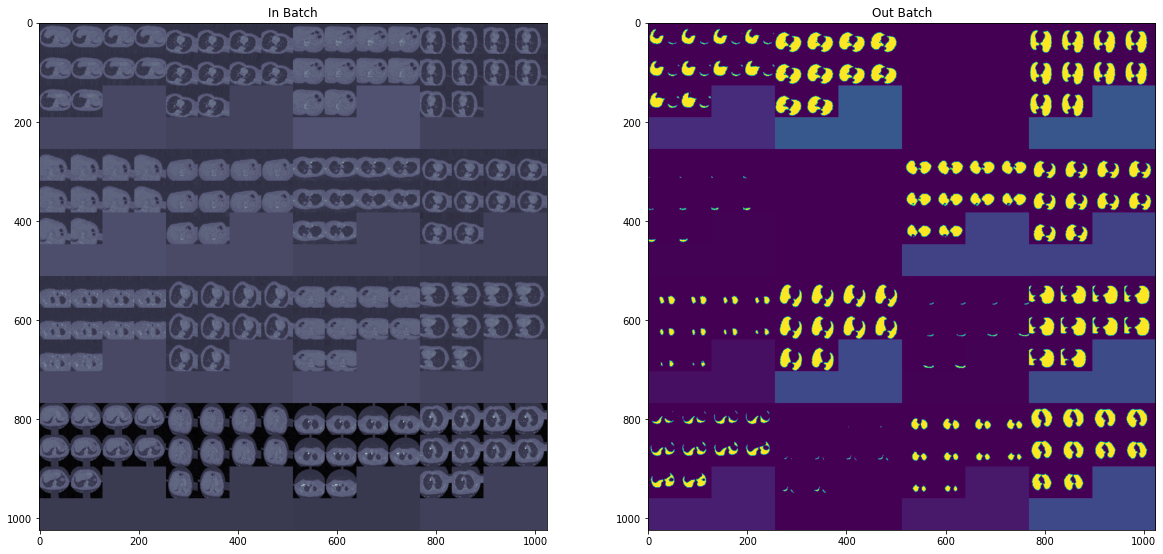

In [9]:
from keras.preprocessing.image import ImageDataGenerator
d_gen = ImageDataGenerator(rotation_range=15, 
                           width_shift_range=0.15, 
                           height_shift_range=0.15, 
                           shear_range=0.1, 
                           zoom_range=0.25, 
                           fill_mode='nearest',
                           horizontal_flip=True, 
                           vertical_flip=False)

def gen_aug_chunk(in_gen):
    for i, (x_img, y_img) in enumerate(in_gen):
        xy_block = np.concatenate([x_img, y_img], 1).swapaxes(1, 4)[:, 0]
        img_gen = d_gen.flow(xy_block, shuffle=True, seed=i, batch_size = x_img.shape[0])
        xy_scat = next(img_gen)
        # unblock
        xy_scat = np.expand_dims(xy_scat,1).swapaxes(1, 4)
        yield xy_scat[:, :xy_scat.shape[1]//2], xy_scat[:, xy_scat.shape[1]//2:]

train_aug_gen = gen_aug_chunk(train_gen)
x_out, y_out = next(train_aug_gen)
print(x_out.shape, y_out.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_nd(x_out[...,0]), cmap = 'bone')
ax1.set_title('In Batch')
ax2.imshow(montage_nd(y_out[...,0]))
ax2.set_title('Out Batch');


In [10]:
"""
AlexNet Keras Implementation
"""


# Import necessary components to build LeNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, LSTM
from tensorflow.keras.layers import BatchNormalization, InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import TimeDistributed, RNN, ConvLSTM2D

import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export

class ConvRNN2D(RNN):
  """Base class for convolutional-recurrent layers.
  Args:
    cell: A RNN cell instance. A RNN cell is a class that has:
      - a `call(input_at_t, states_at_t)` method, returning
        `(output_at_t, states_at_t_plus_1)`. The call method of the
        cell can also take the optional argument `constants`, see
        section "Note on passing external constants" below.
      - a `state_size` attribute. This can be a single integer
        (single state) in which case it is
        the number of channels of the recurrent state
        (which should be the same as the number of channels of the cell
        output). This can also be a list/tuple of integers
        (one size per state). In this case, the first entry
        (`state_size[0]`) should be the same as
        the size of the cell output.
    return_sequences: Boolean. Whether to return the last output.
      in the output sequence, or the full sequence.
    return_state: Boolean. Whether to return the last state
      in addition to the output.
    go_backwards: Boolean (default False).
      If True, process the input sequence backwards and return the
      reversed sequence.
    stateful: Boolean (default False). If True, the last state
      for each sample at index i in a batch will be used as initial
      state for the sample of index i in the following batch.
    input_shape: Use this argument to specify the shape of the
      input when this layer is the first one in a model.
  Call arguments:
    inputs: A 5D tensor.
    mask: Binary tensor of shape `(samples, timesteps)` indicating whether
      a given timestep should be masked.
    training: Python boolean indicating whether the layer should behave in
      training mode or in inference mode. This argument is passed to the cell
      when calling it. This is for use with cells that use dropout.
    initial_state: List of initial state tensors to be passed to the first
      call of the cell.
    constants: List of constant tensors to be passed to the cell at each
      timestep.
  Input shape:
    5D tensor with shape:
    `(samples, timesteps, channels, rows, cols)`
    if data_format='channels_first' or 5D tensor with shape:
    `(samples, timesteps, rows, cols, channels)`
    if data_format='channels_last'.
  Output shape:
    - If `return_state`: a list of tensors. The first tensor is
      the output. The remaining tensors are the last states,
      each 4D tensor with shape:
      `(samples, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 4D tensor with shape:
      `(samples, new_rows, new_cols, filters)`
      if data_format='channels_last'.
      `rows` and `cols` values might have changed due to padding.
    - If `return_sequences`: 5D tensor with shape:
      `(samples, timesteps, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 5D tensor with shape:
      `(samples, timesteps, new_rows, new_cols, filters)`
      if data_format='channels_last'.
    - Else, 4D tensor with shape:
      `(samples, filters, new_rows, new_cols)`
      if data_format='channels_first'
      or 4D tensor with shape:
      `(samples, new_rows, new_cols, filters)`
      if data_format='channels_last'.
  Masking:
    This layer supports masking for input data with a variable number
    of timesteps.
  Note on using statefulness in RNNs:
    You can set RNN layers to be 'stateful', which means that the states
    computed for the samples in one batch will be reused as initial states
    for the samples in the next batch. This assumes a one-to-one mapping
    between samples in different successive batches.
    To enable statefulness:
      - Specify `stateful=True` in the layer constructor.
      - Specify a fixed batch size for your model, by passing
         - If sequential model:
            `batch_input_shape=(...)` to the first layer in your model.
         - If functional model with 1 or more Input layers:
            `batch_shape=(...)` to all the first layers in your model.
            This is the expected shape of your inputs
            *including the batch size*.
            It should be a tuple of integers,
            e.g. `(32, 10, 100, 100, 32)`.
            Note that the number of rows and columns should be specified
            too.
      - Specify `shuffle=False` when calling fit().
    To reset the states of your model, call `.reset_states()` on either
    a specific layer, or on your entire model.
  Note on specifying the initial state of RNNs:
    You can specify the initial state of RNN layers symbolically by
    calling them with the keyword argument `initial_state`. The value of
    `initial_state` should be a tensor or list of tensors representing
    the initial state of the RNN layer.
    You can specify the initial state of RNN layers numerically by
    calling `reset_states` with the keyword argument `states`. The value of
    `states` should be a numpy array or list of numpy arrays representing
    the initial state of the RNN layer.
  Note on passing external constants to RNNs:
    You can pass "external" constants to the cell using the `constants`
    keyword argument of `RNN.__call__` (as well as `RNN.call`) method. This
    requires that the `cell.call` method accepts the same keyword argument
    `constants`. Such constants can be used to condition the cell
    transformation on additional static inputs (not changing over time),
    a.k.a. an attention mechanism.
  """

  def __init__(self,
               cell,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               unroll=False,
               **kwargs):
    if unroll:
      raise TypeError('Unrolling isn\'t possible with '
                      'convolutional RNNs.')
    if isinstance(cell, (list, tuple)):
      # The StackedConvRNN2DCells isn't implemented yet.
      raise TypeError('It is not possible at the moment to'
                      'stack convolutional cells.')
    super(ConvRNN2D, self).__init__(cell,
                                    return_sequences,
                                    return_state,
                                    go_backwards,
                                    stateful,
                                    unroll,
                                    **kwargs)
    self.input_spec = [InputSpec(ndim=5)]
    self.states = None
    self._num_constants = None

  @tf_utils.shape_type_conversion
  def compute_output_shape(self, input_shape):
    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    cell = self.cell
    if cell.data_format == 'channels_first':
      rows = input_shape[3]
      cols = input_shape[4]
    elif cell.data_format == 'channels_last':
      rows = input_shape[2]
      cols = input_shape[3]
    rows = conv_utils.conv_output_length(rows,
                                         cell.kernel_size[0],
                                         padding=cell.padding,
                                         stride=cell.strides[0],
                                         dilation=cell.dilation_rate[0])
    cols = conv_utils.conv_output_length(cols,
                                         cell.kernel_size[1],
                                         padding=cell.padding,
                                         stride=cell.strides[1],
                                         dilation=cell.dilation_rate[1])

    if cell.data_format == 'channels_first':
      output_shape = input_shape[:2] + (cell.filters, rows, cols)
    elif cell.data_format == 'channels_last':
      output_shape = input_shape[:2] + (rows, cols, cell.filters)

    if not self.return_sequences:
      output_shape = output_shape[:1] + output_shape[2:]

    if self.return_state:
      output_shape = [output_shape]
      if cell.data_format == 'channels_first':
        output_shape += [(input_shape[0], cell.filters, rows, cols)
                         for _ in range(2)]
      elif cell.data_format == 'channels_last':
        output_shape += [(input_shape[0], rows, cols, cell.filters)
                         for _ in range(2)]
    return output_shape

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    # Note input_shape will be list of shapes of initial states and
    # constants if these are passed in __call__.
    if self._num_constants is not None:
      constants_shape = input_shape[-self._num_constants:]  # pylint: disable=E1130
    else:
      constants_shape = None

    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    batch_size = input_shape[0] if self.stateful else None
    self.input_spec[0] = InputSpec(shape=(batch_size, None) + input_shape[2:5])

    # allow cell (if layer) to build before we set or validate state_spec
    if isinstance(self.cell, Layer):
      step_input_shape = (input_shape[0],) + input_shape[2:]
      if constants_shape is not None:
        self.cell.build([step_input_shape] + constants_shape)
      else:
        self.cell.build(step_input_shape)

    # set or validate state_spec
    if hasattr(self.cell.state_size, '__len__'):
      state_size = list(self.cell.state_size)
    else:
      state_size = [self.cell.state_size]

    if self.state_spec is not None:
      # initial_state was passed in call, check compatibility
      if self.cell.data_format == 'channels_first':
        ch_dim = 1
      elif self.cell.data_format == 'channels_last':
        ch_dim = 3
      if [spec.shape[ch_dim] for spec in self.state_spec] != state_size:
        raise ValueError(
            'An initial_state was passed that is not compatible with '
            '`cell.state_size`. Received `state_spec`={}; '
            'However `cell.state_size` is '
            '{}'.format([spec.shape for spec in self.state_spec],
                        self.cell.state_size))
    else:
      if self.cell.data_format == 'channels_first':
        self.state_spec = [InputSpec(shape=(None, dim, None, None))
                           for dim in state_size]
      elif self.cell.data_format == 'channels_last':
        self.state_spec = [InputSpec(shape=(None, None, None, dim))
                           for dim in state_size]
    if self.stateful:
      self.reset_states()
    self.built = True

  def get_initial_state(self, inputs):
    # (samples, timesteps, rows, cols, filters)
    initial_state = K.zeros_like(inputs)
    # (samples, rows, cols, filters)
    initial_state = K.sum(initial_state, axis=1)
    shape = list(self.cell.kernel_shape)
    shape[-1] = self.cell.filters
    initial_state = self.cell.input_conv(initial_state,
                                         array_ops.zeros(tuple(shape),
                                                         initial_state.dtype),
                                         padding=self.cell.padding)

    if hasattr(self.cell.state_size, '__len__'):
      return [initial_state for _ in self.cell.state_size]
    else:
      return [initial_state]

  def call(self,
           inputs,
           mask=None,
           training=None,
           initial_state=None,
           constants=None):
    # note that the .build() method of subclasses MUST define
    # self.input_spec and self.state_spec with complete input shapes.
    inputs, initial_state, constants = self._process_inputs(
        inputs, initial_state, constants)

    if isinstance(mask, list):
      mask = mask[0]
    timesteps = K.int_shape(inputs)[1]

    kwargs = {}
    if generic_utils.has_arg(self.cell.call, 'training'):
      kwargs['training'] = training

    if constants:
      if not generic_utils.has_arg(self.cell.call, 'constants'):
        raise ValueError('RNN cell does not support constants')

      def step(inputs, states):
        constants = states[-self._num_constants:]  # pylint: disable=invalid-unary-operand-type
        states = states[:-self._num_constants]  # pylint: disable=invalid-unary-operand-type
        return self.cell.call(inputs, states, constants=constants, **kwargs)
    else:
      def step(inputs, states):
        return self.cell.call(inputs, states, **kwargs)

    last_output, outputs, states = K.rnn(step,
                                         inputs,
                                         initial_state,
                                         constants=constants,
                                         go_backwards=self.go_backwards,
                                         mask=mask,
                                         input_length=timesteps)
    if self.stateful:
      updates = [
          K.update(self_state, state)
          for self_state, state in zip(self.states, states)
      ]
      self.add_update(updates)

    if self.return_sequences:
      output = outputs
    else:
      output = last_output

    if self.return_state:
      if not isinstance(states, (list, tuple)):
        states = [states]
      else:
        states = list(states)
      return [output] + states
    else:
      return output

  def reset_states(self, states=None):
    if not self.stateful:
      raise AttributeError('Layer must be stateful.')
    input_shape = self.input_spec[0].shape
    state_shape = self.compute_output_shape(input_shape)
    if self.return_state:
      state_shape = state_shape[0]
    if self.return_sequences:
      state_shape = state_shape[:1].concatenate(state_shape[2:])
    if None in state_shape:
      raise ValueError('If a RNN is stateful, it needs to know '
                       'its batch size. Specify the batch size '
                       'of your input tensors: \n'
                       '- If using a Sequential model, '
                       'specify the batch size by passing '
                       'a `batch_input_shape` '
                       'argument to your first layer.\n'
                       '- If using the functional API, specify '
                       'the time dimension by passing a '
                       '`batch_shape` argument to your Input layer.\n'
                       'The same thing goes for the number of rows and '
                       'columns.')

    # helper function
    def get_tuple_shape(nb_channels):
      result = list(state_shape)
      if self.cell.data_format == 'channels_first':
        result[1] = nb_channels
      elif self.cell.data_format == 'channels_last':
        result[3] = nb_channels
      else:
        raise KeyError
      return tuple(result)

    # initialize state if None
    if self.states[0] is None:
      if hasattr(self.cell.state_size, '__len__'):
        self.states = [K.zeros(get_tuple_shape(dim))
                       for dim in self.cell.state_size]
      else:
        self.states = [K.zeros(get_tuple_shape(self.cell.state_size))]
    elif states is None:
      if hasattr(self.cell.state_size, '__len__'):
        for state, dim in zip(self.states, self.cell.state_size):
          K.set_value(state, np.zeros(get_tuple_shape(dim)))
      else:
        K.set_value(self.states[0],
                    np.zeros(get_tuple_shape(self.cell.state_size)))
    else:
      if not isinstance(states, (list, tuple)):
        states = [states]
      if len(states) != len(self.states):
        raise ValueError('Layer ' + self.name + ' expects ' +
                         str(len(self.states)) + ' states, ' +
                         'but it received ' + str(len(states)) +
                         ' state values. Input received: ' + str(states))
      for index, (value, state) in enumerate(zip(states, self.states)):
        if hasattr(self.cell.state_size, '__len__'):
          dim = self.cell.state_size[index]
        else:
          dim = self.cell.state_size
        if value.shape != get_tuple_shape(dim):
          raise ValueError('State ' + str(index) +
                           ' is incompatible with layer ' +
                           self.name + ': expected shape=' +
                           str(get_tuple_shape(dim)) +
                           ', found shape=' + str(value.shape))
        # TODO(anjalisridhar): consider batch calls to `set_value`.
        K.set_value(state, value)


class ConvFF2DCell(DropoutRNNCellMixin, Layer):

  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    super(ConvFF2DCell, self).__init__(**kwargs)
    self.filters = filters
    self.kernel_size = conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
    self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
    self.padding = conv_utils.normalize_padding(padding)
    self.data_format = conv_utils.normalize_data_format(data_format)
    self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, 2,
                                                    'dilation_rate')
    self.activation = activations.get(activation)
    self.recurrent_activation = activations.get(recurrent_activation)
    self.use_bias = use_bias

    self.kernel_initializer = initializers.get(kernel_initializer)
    self.recurrent_initializer = initializers.get(recurrent_initializer)
    self.bias_initializer = initializers.get(bias_initializer)
    self.unit_forget_bias = unit_forget_bias

    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)

    self.kernel_constraint = constraints.get(kernel_constraint)
    self.recurrent_constraint = constraints.get(recurrent_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.dropout = min(1., max(0., dropout))
    self.recurrent_dropout = min(1., max(0., recurrent_dropout))
    self.state_size = (self.filters, self.filters)

  def build(self, input_shape):

    if self.data_format == 'channels_first':
      channel_axis = 1
    else:
      channel_axis = -1
    if input_shape[channel_axis] is None:
      raise ValueError('The channel dimension of the inputs '
                       'should be defined. Found `None`.')
    input_dim = input_shape[channel_axis]
    kernel_shape = self.kernel_size + (input_dim, self.filters * 2)
    self.kernel_shape = kernel_shape
    recurrent_kernel_shape = self.kernel_size + (self.filters, self.filters * 2)

    self.kernel = self.add_weight(shape=kernel_shape,
                                  initializer=self.kernel_initializer,
                                  name='kernel',
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
    self.recurrent_kernel = self.add_weight(
        shape=recurrent_kernel_shape,
        initializer=self.recurrent_initializer,
        name='recurrent_kernel',
        regularizer=self.recurrent_regularizer,
        constraint=self.recurrent_constraint)

    if self.use_bias:
      if self.unit_forget_bias:

        def bias_initializer(_, *args, **kwargs):
          return K.concatenate([
              self.bias_initializer((self.filters * 2,), *args, **kwargs),
          ])
      else:
        bias_initializer = self.bias_initializer
      self.bias = self.add_weight(
          shape=(self.filters * 2,),
          name='bias',
          initializer=bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint)
    else:
      self.bias = None
    self.built = True

  def call(self, inputs, states, training=None):

    h_tm1 = states[0]  # previous memory state

    # dropout matrices for input units
    dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=2)
    # dropout matrices for recurrent units
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        h_tm1, training, count=2)

    if 0 < self.dropout < 1.:
      inputs_j = inputs * dp_mask[0]
      inputs_k = inputs * dp_mask[1]

    else:
      inputs_j = inputs
      inputs_k = inputs

    if 0 < self.recurrent_dropout < 1.:
      h_tm1_j = h_tm1 * rec_dp_mask[0]
      h_tm1_k = h_tm1 * rec_dp_mask[1]
    else:
      h_tm1_j = h_tm1
      h_tm1_k = h_tm1

    (kernel_j, kernel_k) = array_ops.split(self.kernel, 2, axis=3)
    (recurrent_kernel_j,
     recurrent_kernel_k) = array_ops.split(self.recurrent_kernel, 2, axis=3)

    if self.use_bias:
      bias_j, bias_k = array_ops.split(self.bias, 2)
    else:
      bias_j, bias_k = None, None

    x_j = self.input_conv(inputs_j, kernel_j, bias_j, padding=self.padding)
    x_k = self.input_conv(inputs_k, kernel_k, bias_k, padding=self.padding)

    h_j = self.recurrent_conv(h_tm1_j, recurrent_kernel_j)
    h_k = self.recurrent_conv(h_tm1_k, recurrent_kernel_k)

    j = self.recurrent_activation(x_j + h_j)
    k = self.recurrent_activation(x_k + h_k)

    v = (1 - h_tm1) * j + (1 - k)* h_tm1

    return v, [v, v]

  def input_conv(self, x, w, b=None, padding='valid'):
    conv_out = K.conv2d(x, w, strides=self.strides,
                        padding=padding,
                        data_format=self.data_format,
                        dilation_rate=self.dilation_rate)
    if b is not None:
      conv_out = K.bias_add(conv_out, b,
                            data_format=self.data_format)
    return conv_out

  def recurrent_conv(self, x, w):
    conv_out = K.conv2d(x, w, strides=(1, 1),
                        padding='same',
                        data_format=self.data_format)
    return conv_out

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'unit_forget_bias': self.unit_forget_bias,
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvFF2DCell, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


@keras_export('keras.layers.ConvFF2D')
class ConvFF2D(ConvRNN2D):


  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    cell = ConvFF2DCell(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides,
                          padding=padding,
                          data_format=data_format,
                          dilation_rate=dilation_rate,
                          activation=activation,
                          recurrent_activation=recurrent_activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          unit_forget_bias=unit_forget_bias,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          dtype=kwargs.get('dtype'))
    super(ConvFF2D, self).__init__(cell,
                                     return_sequences=return_sequences,
                                     return_state=return_state,
                                     go_backwards=go_backwards,
                                     stateful=stateful,
                                     **kwargs)
    self.activity_regularizer = regularizers.get(activity_regularizer)

  def call(self, inputs, mask=None, training=None, initial_state=None):
    return super(ConvFF2D, self).call(inputs,
                                        mask=mask,
                                        training=training,
                                        initial_state=initial_state)

  @property
  def filters(self):
    return self.cell.filters

  @property
  def kernel_size(self):
    return self.cell.kernel_size

  @property
  def strides(self):
    return self.cell.strides

  @property
  def padding(self):
    return self.cell.padding

  @property
  def data_format(self):
    return self.cell.data_format

  @property
  def dilation_rate(self):
    return self.cell.dilation_rate

  @property
  def activation(self):
    return self.cell.activation

  @property
  def recurrent_activation(self):
    return self.cell.recurrent_activation

  @property
  def use_bias(self):
    return self.cell.use_bias

  @property
  def kernel_initializer(self):
    return self.cell.kernel_initializer

  @property
  def recurrent_initializer(self):
    return self.cell.recurrent_initializer

  @property
  def bias_initializer(self):
    return self.cell.bias_initializer

  @property
  def unit_forget_bias(self):
    return self.cell.unit_forget_bias

  @property
  def kernel_regularizer(self):
    return self.cell.kernel_regularizer

  @property
  def recurrent_regularizer(self):
    return self.cell.recurrent_regularizer

  @property
  def bias_regularizer(self):
    return self.cell.bias_regularizer

  @property
  def kernel_constraint(self):
    return self.cell.kernel_constraint

  @property
  def recurrent_constraint(self):
    return self.cell.recurrent_constraint

  @property
  def bias_constraint(self):
    return self.cell.bias_constraint

  @property
  def dropout(self):
    return self.cell.dropout

  @property
  def recurrent_dropout(self):
    return self.cell.recurrent_dropout

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'unit_forget_bias': self.unit_forget_bias,
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'activity_regularizer': regularizers.serialize(
                  self.activity_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvFF2D, self).get_config()
    del base_config['cell']
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [11]:
from keras.layers import ConvLSTM2D, Bidirectional, BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D
from keras.models import Sequential
sim_model = Sequential()
sim_model.add(BatchNormalization(input_shape = (None, None, None, 1)))
sim_model.add(Conv3D(8, 
                     kernel_size = (1, 5, 5), 
                     padding = 'same',
                     activation = 'relu'))
sim_model.add(Conv3D(8, 
                     kernel_size = (3, 3, 3), 
                     padding = 'same',
                     activation = 'relu'))
sim_model.add(BatchNormalization())
sim_model.add(Bidirectional(ConvFF2D(16, 
                                       kernel_size = (3, 3),
                                       padding = 'same',
                                       return_sequences = True)))
sim_model.add(Bidirectional(ConvFF2D(32, 
                                       kernel_size = (3, 3),
                                       padding = 'same',
                                       return_sequences = True)))
sim_model.add(Conv3D(8, 
                     kernel_size = (1, 3, 3), 
                     padding = 'same',
                     activation = 'relu'))
sim_model.add(Conv3D(1, 
                     kernel_size = (1,1,1), 
                     activation = 'sigmoid'))
sim_model.add(Cropping3D((1, 2, 2))) # avoid skewing boundaries
sim_model.add(ZeroPadding3D((1, 2, 2)))
sim_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, None, None, None,  4         
_________________________________________________________________
conv3d (Conv3D)              (None, None, None, None,  208       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, None, None, None,  1736      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, None,  32        
_________________________________________________________________
bidirectional (Bidirectional (None, None, None, None,  13888     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, None, None,  73856     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, None, None, None,  4

In [12]:
sim_model.predict(x_out).shape

(16, 10, 64, 64, 1)

In [14]:
sim_model.load_weights('convlstm_model_weights.best.hdf5')


In [15]:
# ewjkkje

In [ ]:
sim_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['binary_accuracy', 'mse'])
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('convlstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
sim_model.fit_generator(train_aug_gen,
                        epochs=1,
                        steps_per_epoch = 100, 
                        validation_data = valid_gen, 
                        validation_steps=10,
                       callbacks = callbacks_list)

In [16]:
test_single_vol, test_single_mask = read_both(test_paths[0:1])


In [17]:
pred_seg = sim_model.predict(np.expand_dims(test_single_vol,0))[0]


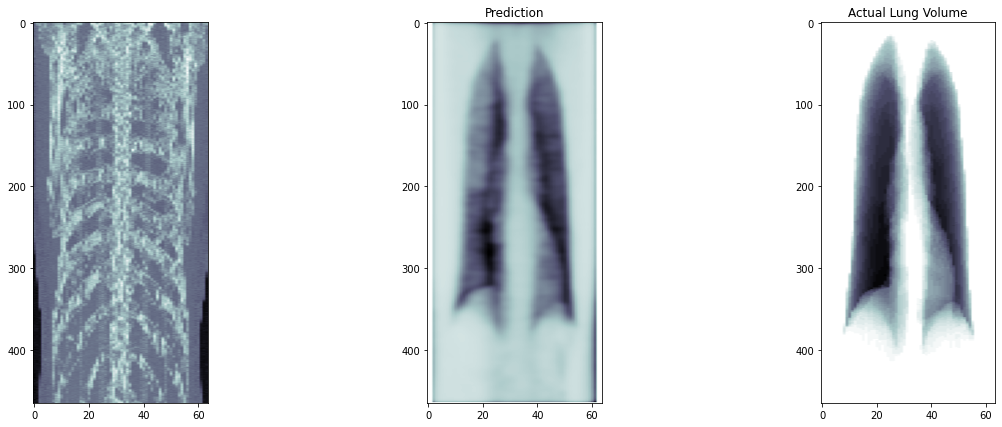

In [18]:
from skimage.util import montage as montage2d
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
ax1.imshow(np.max(test_single_vol[::-1, :, :, 0], 1), cmap = 'bone')
ax1.set_aspect(0.3)
ax2.imshow(np.sum(pred_seg[::-1, :, :, 0], 1), cmap = 'bone_r')
ax2.set_title('Prediction')
ax2.set_aspect(0.3)
ax3.imshow(np.sum(test_single_mask[::-1, :, :, 0], 1), cmap = 'bone_r')
ax3.set_title('Actual Lung Volume')
ax3.set_aspect(0.3)
fig.savefig('full_scan_prediction.png', dpi = 300)

In [ ]:
from keras.layers import ConvLSTM2D, Bidirectional, BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D
from keras.models import Sequential
lsim_model = Sequential()
lsim_model.add(BatchNormalization(input_shape = (None, None, None, 1)))
lsim_model.add(Conv3D(8, 
                     kernel_size = (1, 5, 5), 
                     padding = 'same',
                     activation = 'relu'))
lsim_model.add(Conv3D(8, 
                     kernel_size = (3, 3, 3), 
                     padding = 'same',
                     activation = 'relu'))
lsim_model.add(BatchNormalization())
lsim_model.add(Bidirectional(ConvLSTM2D(16, 
                                       kernel_size = (3, 3),
                                       padding = 'same',
                                       return_sequences = True)))
lsim_model.add(Bidirectional(ConvLSTM2D(32, 
                                       kernel_size = (3, 3),
                                       padding = 'same',
                                       return_sequences = True)))
lsim_model.add(Conv3D(8, 
                     kernel_size = (1, 3, 3), 
                     padding = 'same',
                     activation = 'relu'))
lsim_model.add(Conv3D(1, 
                     kernel_size = (1,1,1), 
                     activation = 'sigmoid'))
lsim_model.add(Cropping3D((1, 2, 2))) # avoid skewing boundaries
lsim_model.add(ZeroPadding3D((1, 2, 2)))
lsim_model.summary()

In [ ]:
lsim_model.predict(x_out).shape # ensure the model works and the result has the right size


In [ ]:
lsim_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['binary_accuracy', 'mse'])
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('convlstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
lsim_model.fit_generator(train_aug_gen,
                        epochs=1,
                        steps_per_epoch = 100, 
                        validation_data = valid_gen, 
                        validation_steps=10,
                       callbacks = callbacks_list)

In [ ]:
from skimage.util import montage as montage2d
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
ax1.imshow(np.max(test_single_vol[::-1, :, :, 0], 1), cmap = 'bone')
ax1.set_aspect(0.3)
ax2.imshow(np.sum(pred_seg[::-1, :, :, 0], 1), cmap = 'bone_r')
ax2.set_title('Prediction')
ax2.set_aspect(0.3)
ax3.imshow(np.sum(test_single_mask[::-1, :, :, 0], 1), cmap = 'bone_r')
ax3.set_title('Actual Lung Volume')
ax3.set_aspect(0.3)
fig.savefig('full_scan_prediction.png', dpi = 300)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
ax1.imshow(montage2d(test_single_vol[::6, :, :, 0]), cmap = 'bone')
ax2.imshow(montage2d(pred_seg[::6, :, :, 0]), cmap = 'viridis')
ax2.set_title('Prediction')
ax3.imshow(montage2d(test_single_mask[::6, :, :, 0]), cmap = 'viridis')
ax3.set_title('Actual Mask')
fig.savefig('subsample_pred.png', dpi = 300)

In [ ]:
from tensorflow import keras
model = keras.models.load_model(r'C:\Users\USER\Desktop\Lehigh_MS\441-Project\Lung-Segmentation-of-2D-and-3D-Scans\convlstm_model_weights.best.hdf5')